<a href="https://colab.research.google.com/github/hiamitabha/course/blob/master/notebooks/TrainVectorWithYolov12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [ ]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Tue May  6 05:32:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [ ]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 68.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [ ]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-05-06 05:34:44--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-05-06 05:34:44 (110 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


100%|██████████| 51.4M/51.4M [00:00<00:00, 128MB/s]


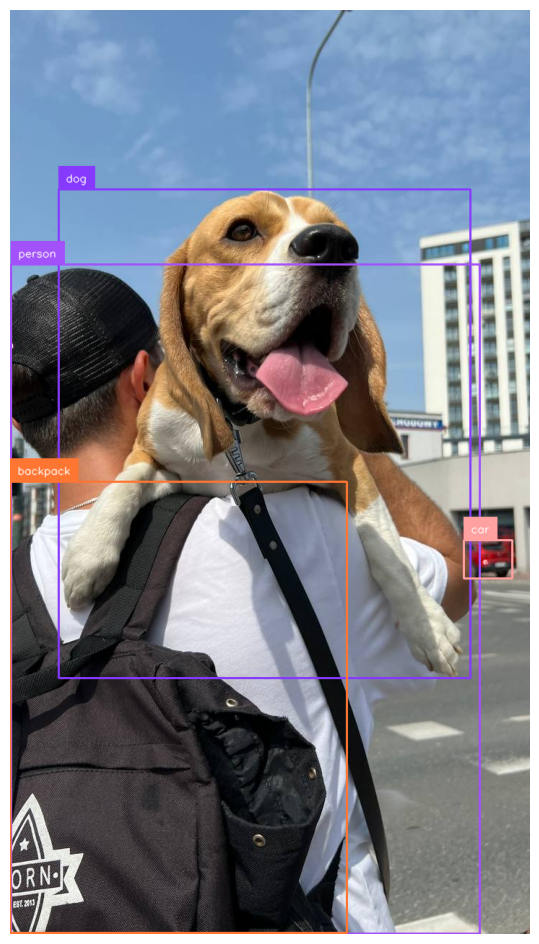

In [ ]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key=os.environ["ROBOFLOW_API_KEY"])
project = rf.workspace("vectorstuff").project("vectorcompletedataset")
version = project.version(9)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to vectorCompleteDataset-9 in yolov8:: 100%|██████████| 2176/2176 [00:00<00:00, 4925.17it/s]


In [ ]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [ ]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [ ]:
!cat {dataset.location}/data.yaml

names:
- vector
nc: 1
roboflow:
  license: CC BY 4.0
  project: vectorcompletedataset
  url: https://universe.roboflow.com/vectorstuff/vectorcompletedataset/dataset/9
  version: 9
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=50)

New https://pypi.org/project/ultralytics/8.3.127 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/vectorCompleteDataset-9/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show

100%|██████████| 755k/755k [00:00<00:00, 18.3MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.26M/5.26M [00:00<00:00, 98.5MB/s]


AMP: checks passed ✅


train: Scanning /content/vectorCompleteDataset-9/train/labels... 1002 images, 27 backgrounds, 0 corrupt: 100%|██████████| 1002/1002 [00:00<00:00, 2349.95it/s]

train: New cache created: /content/vectorCompleteDataset-9/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/vectorCompleteDataset-9/valid/labels... 54 images, 0 backgrounds, 0 corrupt: 100%|██████████| 54/54 [00:00<00:00, 1570.67it/s]

val: New cache created: /content/vectorCompleteDataset-9/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       6.7G      3.025      3.676      4.049         19        640: 100%|██████████| 63/63 [00:36<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         54         54    0.00333          1     0.0308     0.0075



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.83G      2.625      3.139       3.42         17        640: 100%|██████████| 63/63 [00:34<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all         54         54      0.113      0.037     0.0126      0.002



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.67G      2.443      2.646      3.033         22        640: 100%|██████████| 63/63 [00:34<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]

                   all         54         54      0.025      0.259     0.0133    0.00631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.82G      2.227      2.299      2.789         19        640: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                   all         54         54      0.519        0.5      0.573      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.83G      2.011      1.963      2.534         19        640: 100%|██████████| 63/63 [00:34<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]

                   all         54         54      0.669       0.63       0.78      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.81G        1.9      1.769      2.391         22        640: 100%|██████████| 63/63 [00:34<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         54         54      0.798      0.741      0.839      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.84G      1.742      1.571      2.239         26        640: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         54         54      0.953      0.759      0.885      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.82G      1.639      1.448      2.122         22        640: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

                   all         54         54      0.764      0.778      0.895      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.67G      1.536      1.299      2.015         26        640: 100%|██████████| 63/63 [00:34<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         54         54       0.85      0.842      0.939      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.65G      1.462      1.237      1.949         23        640: 100%|██████████| 63/63 [00:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]

                   all         54         54      0.902      0.963      0.982      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.84G      1.414      1.143      1.877         23        640: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

                   all         54         54          1      0.888      0.971      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.82G      1.345      1.115      1.826         27        640: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all         54         54      0.982       0.87      0.982       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.67G      1.307      1.056        1.8         19        640: 100%|██████████| 63/63 [00:34<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         54         54      0.908      0.981      0.982      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.65G      1.269     0.9869      1.766         21        640: 100%|██████████| 63/63 [00:34<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         54         54      0.943      0.917       0.97      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.83G      1.249     0.9736       1.73         24        640: 100%|██████████| 63/63 [00:34<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]

                   all         54         54      0.981      0.964      0.988      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.82G       1.23     0.9571      1.707         22        640: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]

                   all         54         54       0.99      0.889      0.981      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.67G      1.235      0.946      1.702         22        640: 100%|██████████| 63/63 [00:34<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         54         54      0.968      0.963      0.993      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.81G      1.155     0.8825      1.642         26        640: 100%|██████████| 63/63 [00:34<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         54         54      0.892      0.981      0.983      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.84G      1.147     0.8943      1.638         20        640: 100%|██████████| 63/63 [00:34<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all         54         54      0.961      0.981      0.993      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.82G      1.187     0.8895      1.659         18        640: 100%|██████████| 63/63 [00:33<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

                   all         54         54          1      0.897      0.978       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.67G      1.123      0.846      1.607         19        640: 100%|██████████| 63/63 [00:34<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         54         54      0.956      0.944       0.99      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.65G      1.148     0.8513      1.629         20        640: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         54         54      0.986      0.981      0.994      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.84G      1.113     0.8027      1.583         25        640: 100%|██████████| 63/63 [00:34<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         54         54      0.979      0.963      0.991      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.82G      1.042     0.7527      1.537         18        640: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

                   all         54         54      0.989      0.981      0.994       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.67G      1.037     0.7607      1.546         17        640: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]

                   all         54         54      0.982      0.999      0.995      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.65G      1.003     0.7409      1.514         21        640: 100%|██████████| 63/63 [00:34<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         54         54      0.989      0.981      0.995       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.83G      1.009     0.7382       1.51         19        640: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

                   all         54         54      0.991      0.981      0.994      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.82G     0.9859     0.7016      1.477         28        640: 100%|██████████| 63/63 [00:34<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         54         54       0.98          1      0.995      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.83G     0.9735     0.6886      1.463         21        640: 100%|██████████| 63/63 [00:34<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]

                   all         54         54          1      0.993      0.995      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.81G     0.9665     0.6873      1.452         21        640: 100%|██████████| 63/63 [00:33<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all         54         54      0.982          1      0.995      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.67G     0.9348       0.67      1.436         24        640: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         54         54      0.998          1      0.995      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.82G     0.9311     0.6368      1.426         18        640: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         54         54      0.996          1      0.995      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.67G     0.9244     0.6441      1.414         24        640: 100%|██████████| 63/63 [00:34<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         54         54      0.998          1      0.995      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.65G     0.9272     0.6499      1.426         22        640: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         54         54      0.998          1      0.995      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.84G     0.9029     0.6344      1.406         18        640: 100%|██████████| 63/63 [00:34<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

                   all         54         54      0.976      0.981      0.992      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.82G     0.9144     0.6405      1.418         17        640: 100%|██████████| 63/63 [00:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         54         54          1      0.996      0.995       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.67G     0.8773     0.6209      1.388         28        640: 100%|██████████| 63/63 [00:34<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all         54         54          1      0.998      0.995      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.81G     0.8671     0.6095      1.375         19        640: 100%|██████████| 63/63 [00:34<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         54         54          1      0.995      0.995      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.67G     0.8518     0.5943      1.366         25        640: 100%|██████████| 63/63 [00:34<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         54         54          1      0.999      0.995      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.82G     0.8357     0.5764      1.352         21        640: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

                   all         54         54          1      0.999      0.995      0.883


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.67G     0.7082     0.4319       1.27          9        640: 100%|██████████| 63/63 [00:34<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]

                   all         54         54      0.998          1      0.995      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.65G     0.6524     0.3878      1.202          9        640: 100%|██████████| 63/63 [00:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all         54         54          1      0.996      0.995      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.83G     0.6221      0.368      1.178         10        640: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all         54         54      0.998          1      0.995      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.82G     0.6165     0.3669      1.174         10        640: 100%|██████████| 63/63 [00:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

                   all         54         54          1          1      0.995      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.67G     0.5947     0.3544      1.145         10        640: 100%|██████████| 63/63 [00:34<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]

                   all         54         54          1      0.997      0.995      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.65G     0.5748      0.343      1.132         10        640: 100%|██████████| 63/63 [00:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         54         54      0.998          1      0.995      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.84G     0.5689     0.3376      1.128         10        640: 100%|██████████| 63/63 [00:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         54         54          1      0.997      0.995      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.82G     0.5522     0.3324      1.119         10        640: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         54         54      0.999          1      0.995      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.67G     0.5546      0.336       1.12         10        640: 100%|██████████| 63/63 [00:34<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all         54         54          1          1      0.995      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.65G     0.5413     0.3245      1.102         10        640: 100%|██████████| 63/63 [00:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         54         54      0.998          1      0.995      0.919



50 epochs completed in 0.505 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,074,595 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


                   all         54         54      0.998          1      0.995      0.922
Speed: 0.2ms preprocess, 10.4ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train


## Evaluate fine-tuned YOLOv12 model

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					   train_batch0.jpg
confusion_matrix_normalized.png			   train_batch1.jpg
confusion_matrix.png				   train_batch2520.jpg
events.out.tfevents.1746509729.882761ee7aa3.438.0  train_batch2521.jpg
F1_curve.png					   train_batch2522.jpg
labels_correlogram.jpg				   train_batch2.jpg
labels.jpg					   val_batch0_labels.jpg
P_curve.png					   val_batch0_pred.jpg
PR_curve.png					   val_batch1_labels.jpg
R_curve.png					   val_batch1_pred.jpg
results.csv					   weights
results.png


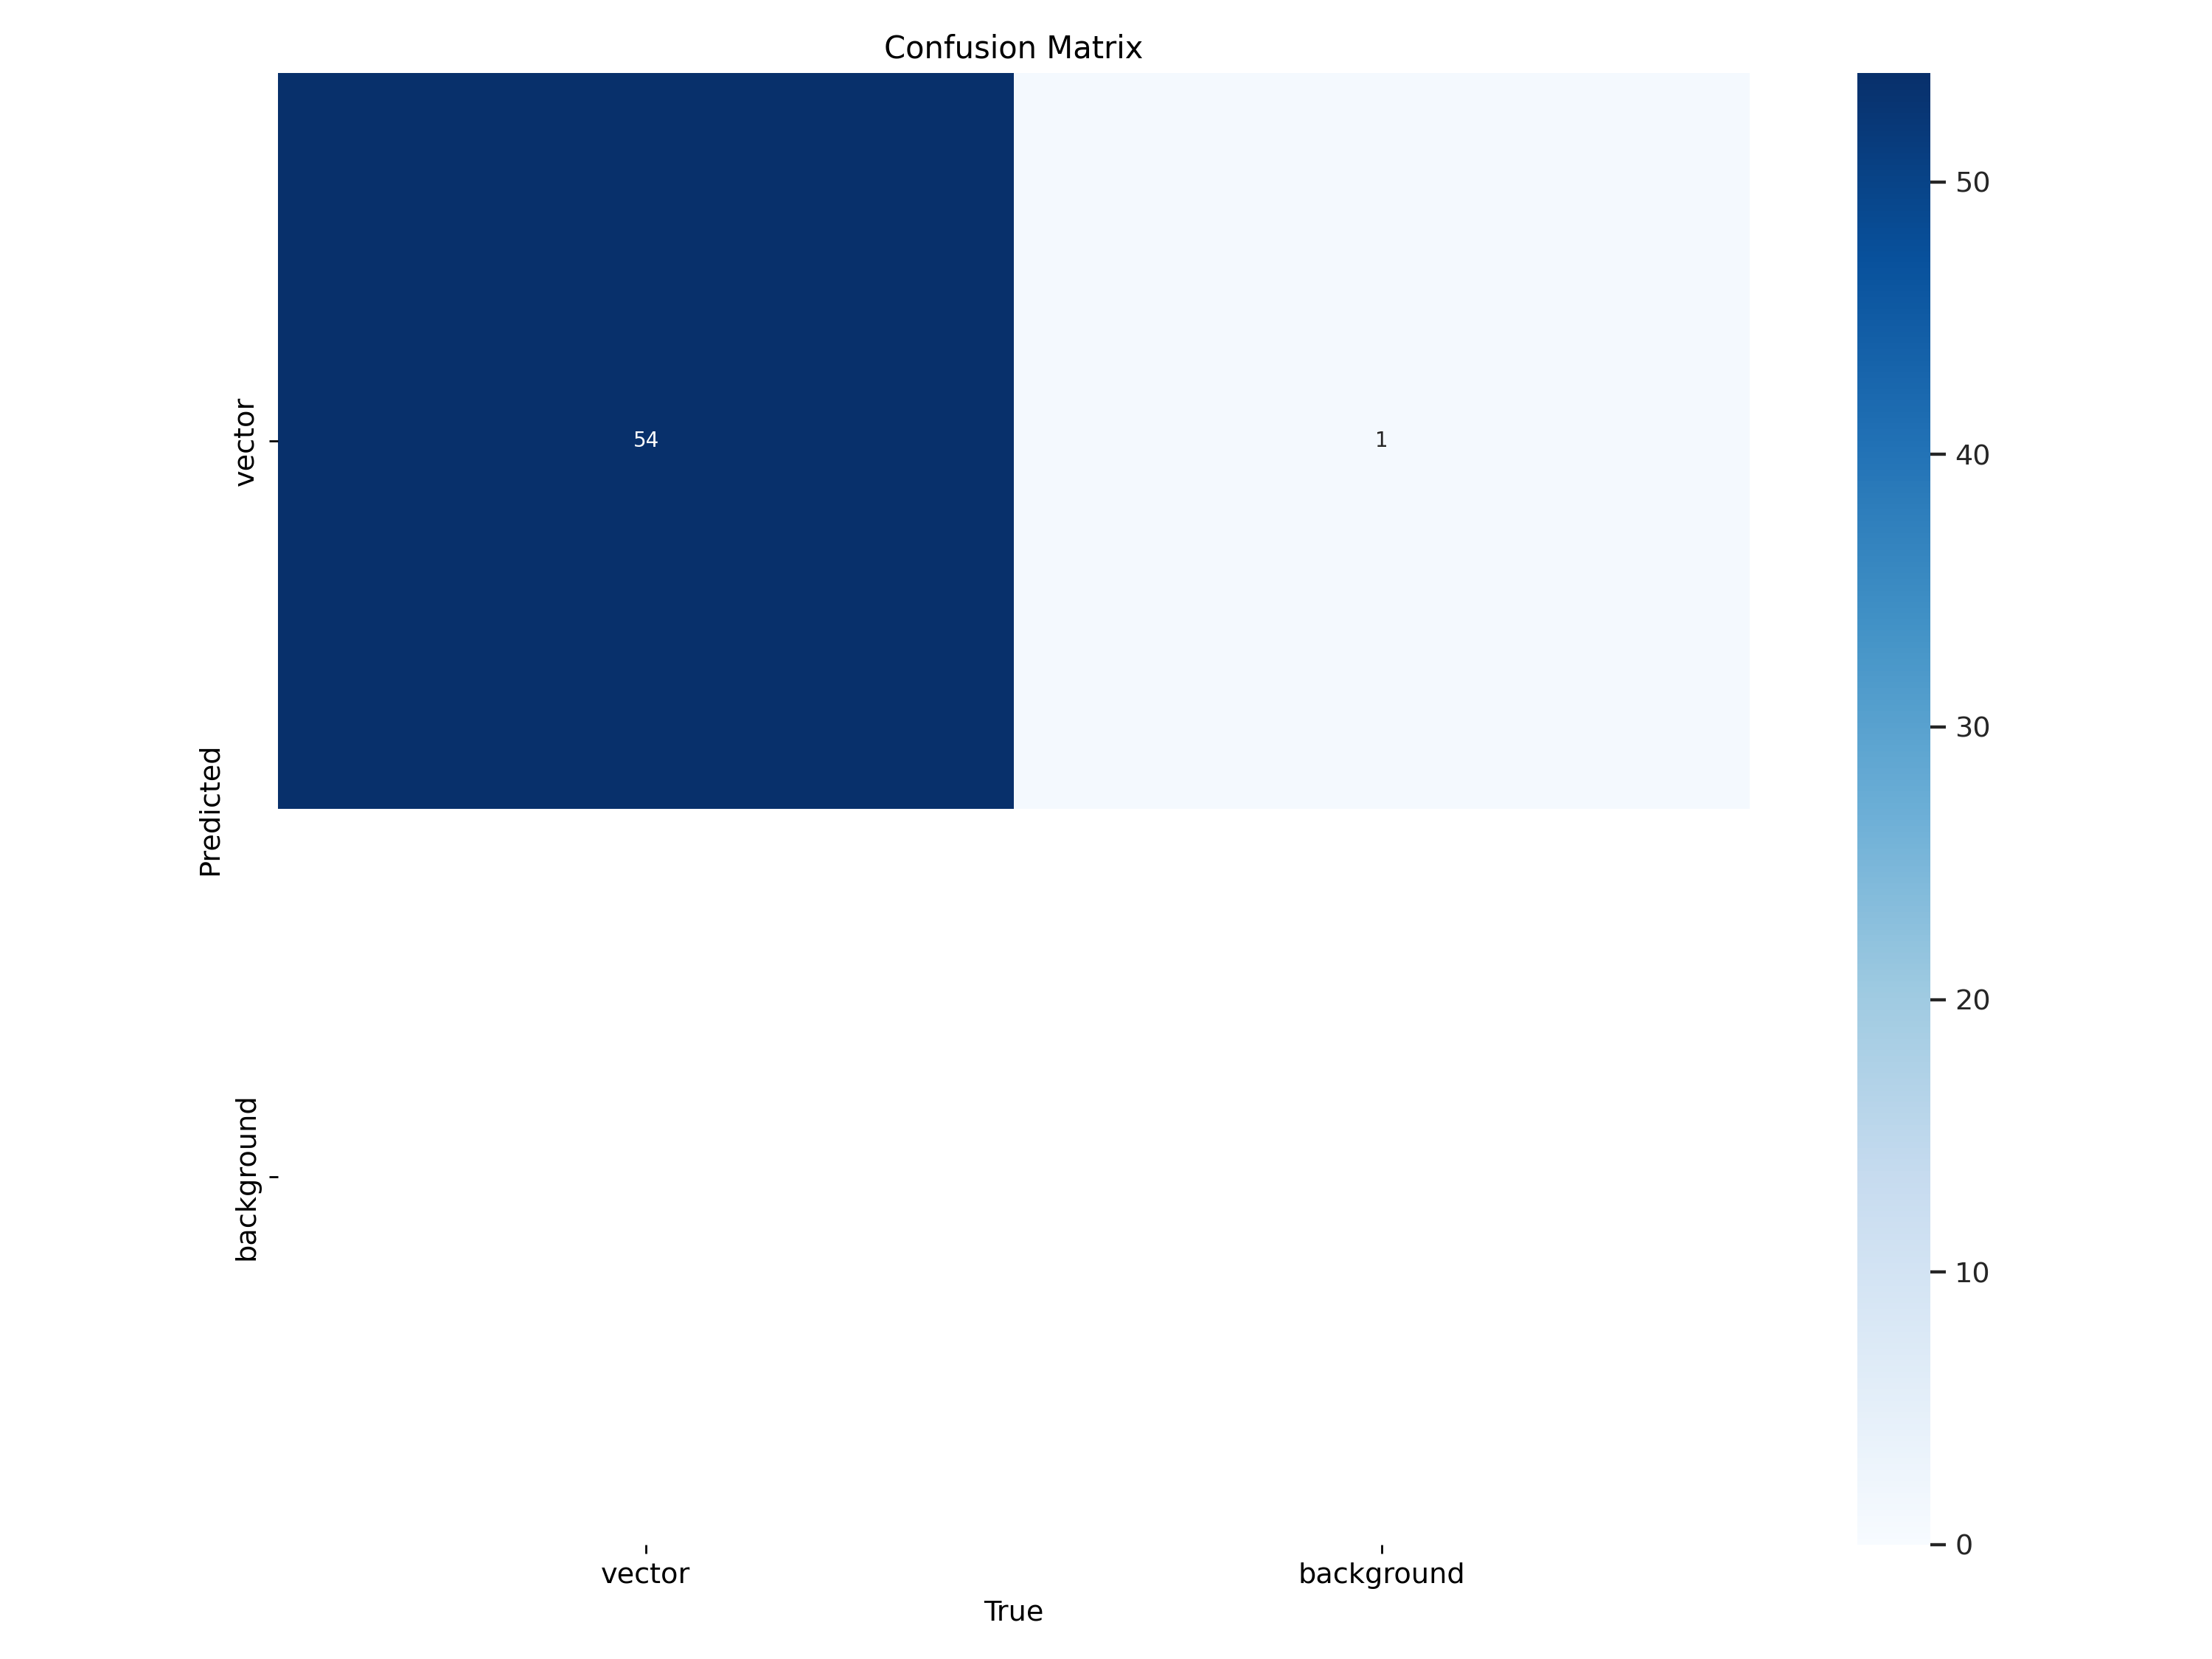

In [ ]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

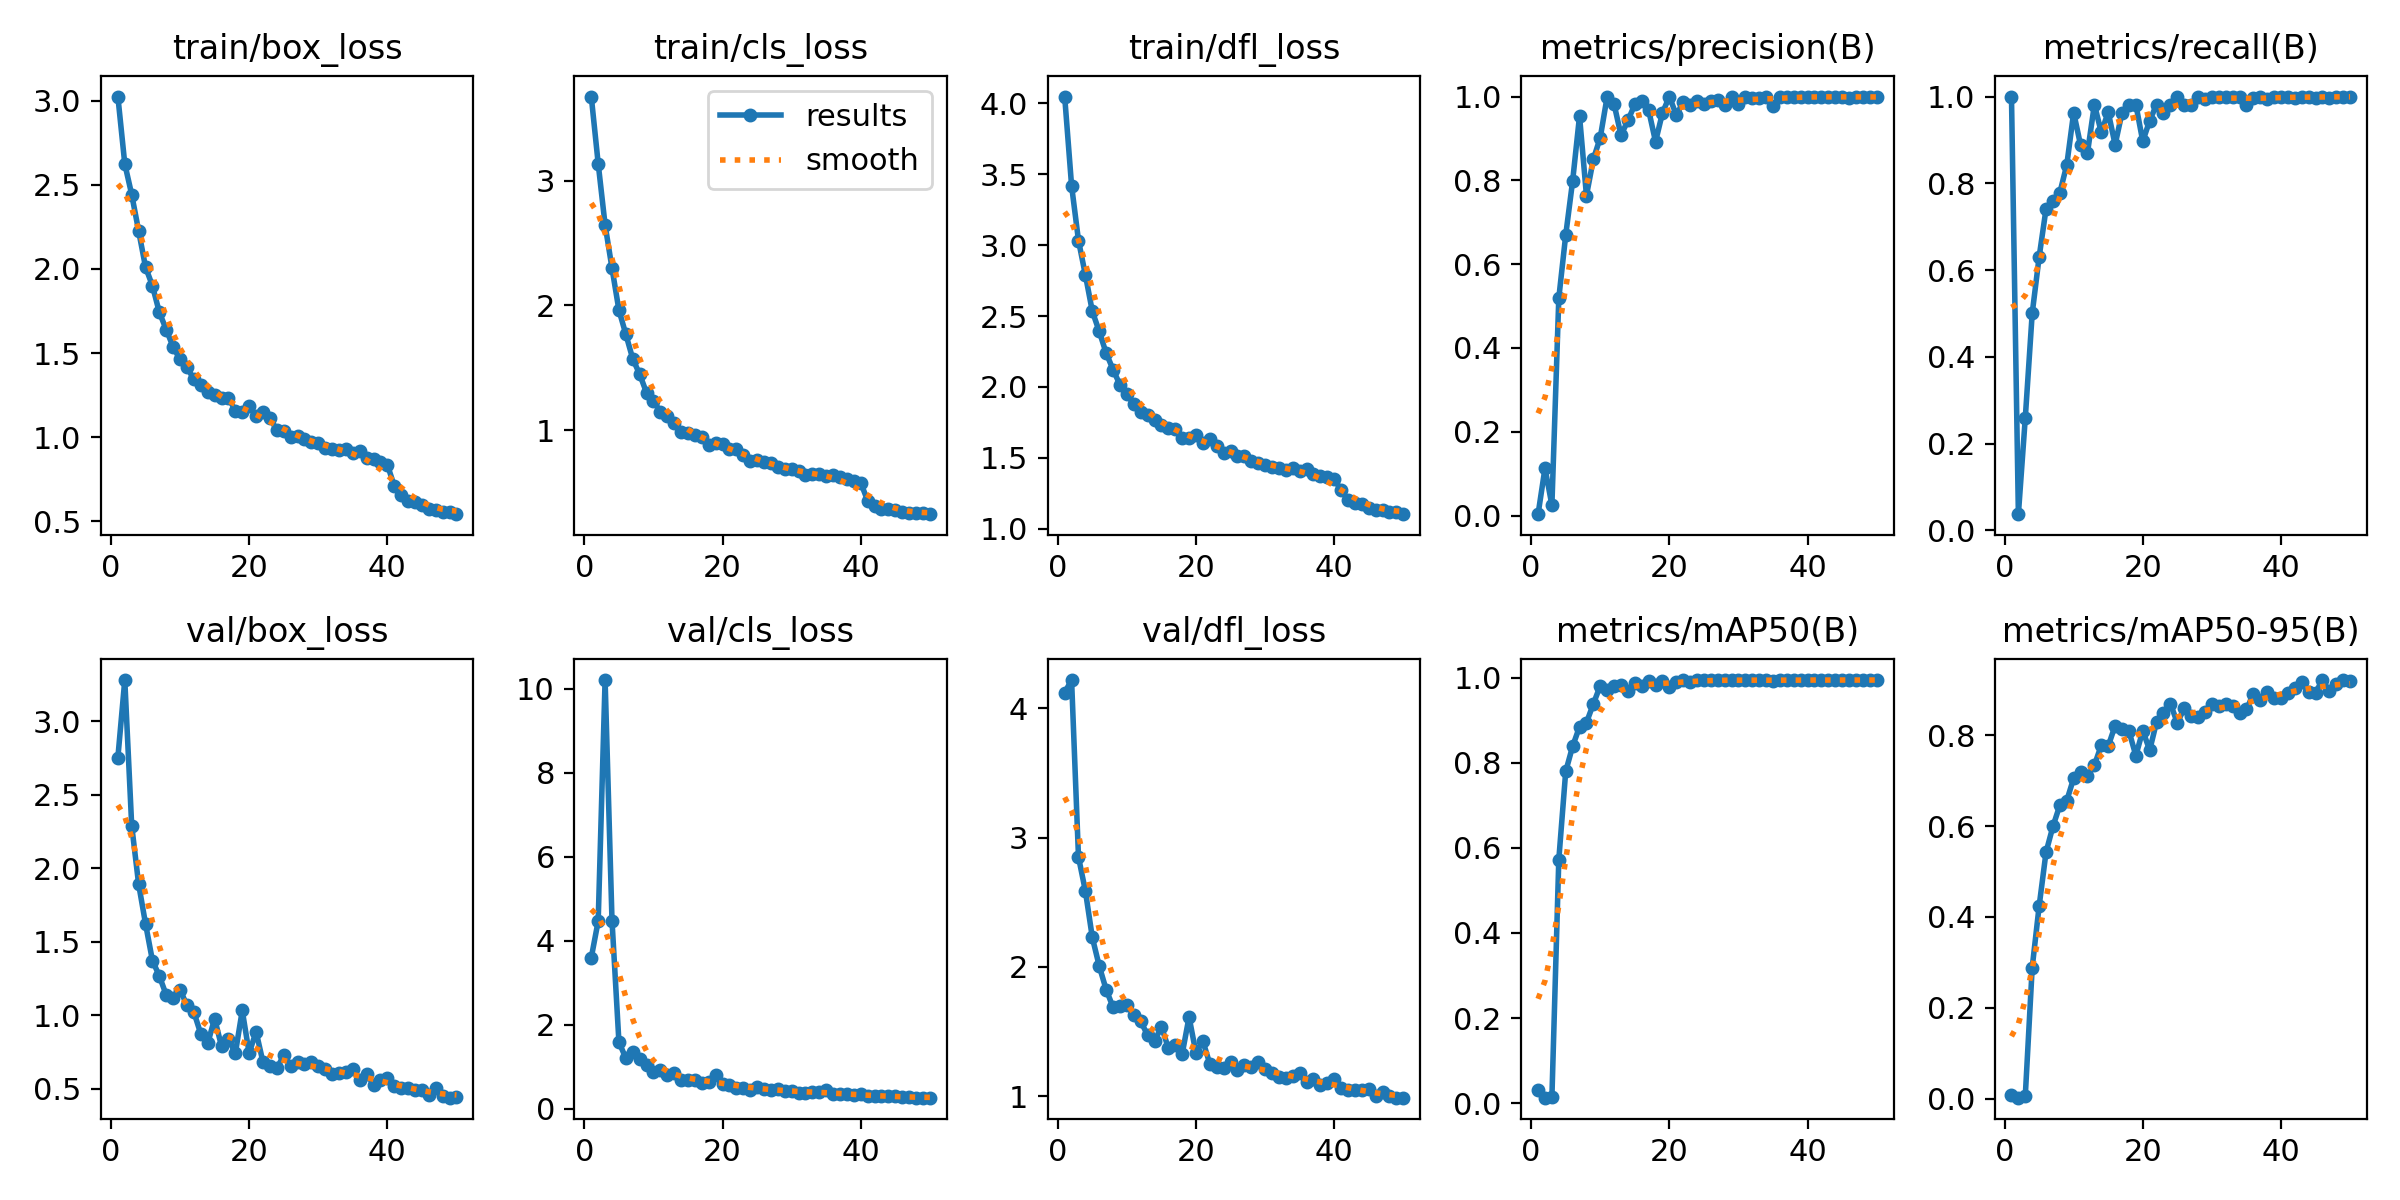

In [ ]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['vector']

In [ ]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [ ]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.894363060866282
mAP 50 0.9999999999999999
mAP 75 0.9999999999999999


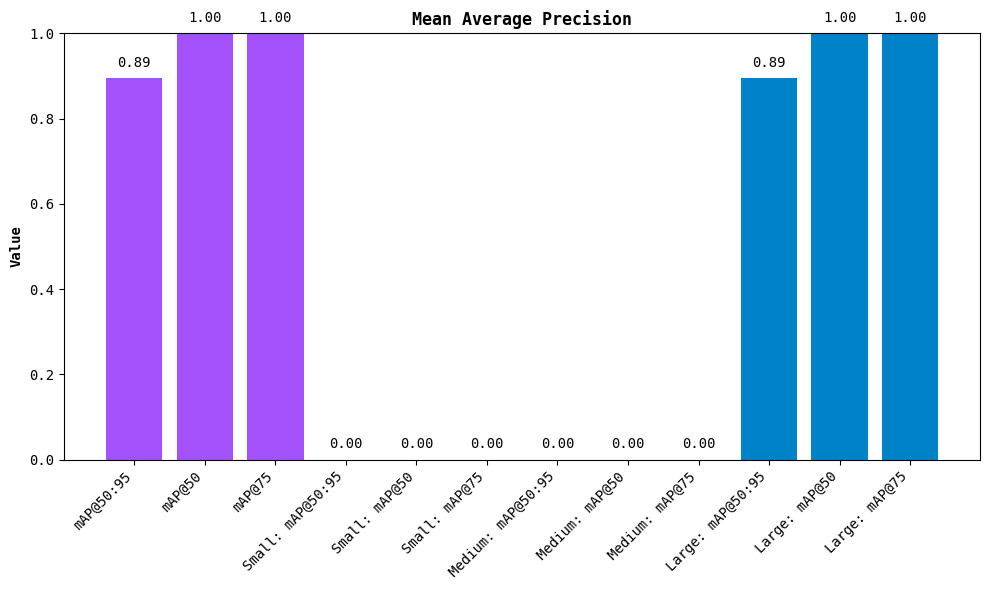

In [ ]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [ ]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

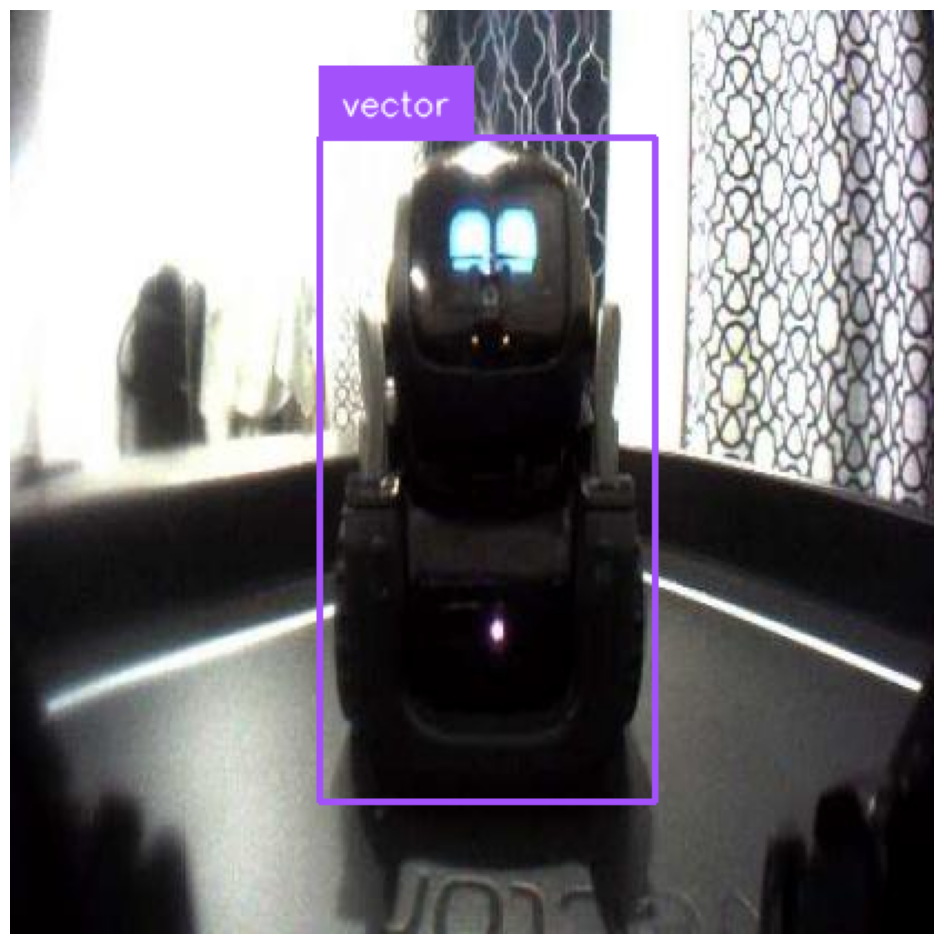

In [ ]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

Upload weights to Roboflow.com

In [ ]:
from roboflow import Roboflow

rf = Roboflow(api_key="Xzg2wL8vamx2wO42BYTQ")
project = rf.workspace().project("vectorcompletedataset")


#can specify weights_filename, default is "weights/best.pt"
version = project.version(6)

version.deploy(
    model_type="yolov12",  # Type of the model
    model_path=f'/{HOME}/runs/detect/train/',  # Path to model directory
    filename="weights/best.pt"  # Path to weights file (default)
)


loading Roboflow workspace...
loading Roboflow project...

!!! ATTENTION !!!
Model must be trained and uploaded using ultralytics from https://github.com/sunsmarterjie/yolov12
or through the Roboflow platform
!!! ATTENTION !!!

View the status of your deployment at: https://app.roboflow.com/vectorstuff/vectorcompletedataset/6
Share your model with the world at: https://universe.roboflow.com/vectorstuff/vectorcompletedataset/model/6


In [ ]:
!ls -l /content/runs/detect/train/weights/

total 36400
-rw-r--r-- 1 root root 18635427 May  6 06:05 best.pt
-rw-r--r-- 1 root root 18635427 May  6 06:05 last.pt
